# Example for running parcels 3.0


The cell below only checks the version for the main Software used in this notebook. However, the environment is locked in the conda-lock.yml file for full reproducibility.

In [1]:
import cartopy
import parcels
import xarray

print(f"{parcels.__version__=}")
print(f"{xarray.__version__=}")
print(f"{cartopy.__version__=}")

parcels.__version__='3.0.0'
xarray.__version__='2023.12.0'
cartopy.__version__='0.22.0'


Download and cache the model data from the GitHub repository. We are using here the model with both winds and tides.

In [2]:
import pooch
import xarray as xr

url = "https://github.com/LaPoGeoMar/Proj_Modelagem_Pellet/releases/download"
version = "v0.1.0"

fname = pooch.retrieve(
    url=f"{url}/{version}/model_tides_and_winds.nc",
    known_hash="sha256:1b01945c529e9f0489a659fc8360344ff58925544a2f7e543148d4f31c6dd0e8",
)

ds = xr.open_dataset(fname)
ds

<xarray.Dataset>
Dimensions:     (time: 8772, m: 138, n: 218)
Coordinates:
    Layer       float32 ...
    latitude    (m, n) float32 ...
    longitude   (m, n) float32 ...
  * m           (m) float32 -48.87 -48.87 -48.86 -48.85 ... -47.53 -47.52 -47.51
  * n           (n) float32 -28.62 -28.62 -28.61 -28.6 ... -26.48 -26.47 -26.47
  * time        (time) datetime64[ns] 2021-01-01 ... 2022-01-01
Data variables:
    waterlevel  (time, m, n) float32 ...
    velocity_x  (time, m, n) float32 ...
    velocity_y  (time, m, n) float32 ...
Attributes: (12/25)
    title:                         NetCDF created from NEFIS-file trim-sc_fl_...
    institution:                   
    source:                        Delft3D trim file
    history:                       Mon Aug 22 14:21:18 2022: ncks -4 -L 1 jan...
    references:                    http://svn.oss.deltares.nl
    email:                         
    ...                            ...
    geospatial_lon_units:          dergees_east
    geospatial_vertical_min:       2.2039968967437744
    geospatial_vertical_max:       547.0967407226562
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  down
    NCO:                           netCDF Operators version 5.1.0 (Homepage =...

We need to trim the borders [1] b/c the duplicated position at the bordes crashes the integration. We also transpose the matrix b/c `parcels` expect the arrays to be in time, lat, lon order.

[1] https://github.com/OceanParcels/parcels/issues/1358
[2] https://github.com/OceanParcels/parcels/issues/1235

In [3]:
ds = ds.isel(
    m=slice(1, -1),
    n=slice(1, -1),
)

ds = ds.transpose("time", "n", "m")

Create the `FieldSet` from the xarray dataset.

In [4]:
from parcels import FieldSet

variables = {
    "U": "velocity_x",
    "V": "velocity_y",
}

dimensions = {
    "U": {
        "time": "time",
        "lat": "n",  # "latitude",
        "lon": "m",  # "longitude",
    },
    "V": {
        "time": "time",
        "lat": "n",  # "latitude",
        "lon": "m",  # "longitude",
    },
}

fieldset = FieldSet.from_xarray_dataset(ds, variables, dimensions)

Find the nearest grid point to the position `x, y` to release the particles.

In [5]:
import numpy as np

offset = 0.1  # make it away from the coast
x, y = -48.66 + offset, -26.89  # Itajaí


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


xi = find_nearest(ds["m"], x)
yi = find_nearest(ds["n"], y)

x = ds["m"][xi]
y = ds["n"][yi]

# Release a line of particles to find the best place for releasing the cluster.
# x = ds["m"][xi:xi+100].to_numpy()[()]
# y = [ds["n"][yi].to_numpy()[()]] * len(x)

Map with the Region of Interest (ROI) and the release point.

In [6]:
import random
from datetime import timedelta

from parcels import JITParticle, ParticleSet, Variable

npart = 10  # number of released particles
lon = [x] * npart  # lon de liberacao das particulas
lat = [y] * npart  # lat da liberacao das particulas
repeatdt = timedelta(hours=24)

lons, lats = [], []
for k in range(npart):
    lons.append(x + random.uniform(-1, 1) * 0.01)
    lats.append(y + random.uniform(-1, 1) * 0.01)


class AgeParticle(JITParticle):
    age = Variable("age", initial=0)


pset = ParticleSet(
    fieldset=fieldset,
    pclass=AgeParticle,
    lon=lons,
    lat=lats,
    repeatdt=repeatdt,
)

domain = {
    "N": ds["latitude"].max().to_numpy()[()],
    "S": ds["latitude"].min().to_numpy()[()],
    "E": ds["longitude"].max().to_numpy()[()],
    "W": ds["longitude"].min().to_numpy()[()],
}

/tmp/ipykernel_41411/4232120704.py:57: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  ax.plot(X, Y, "k.", alpha=0.25, zorder=0, color="lightgrey");


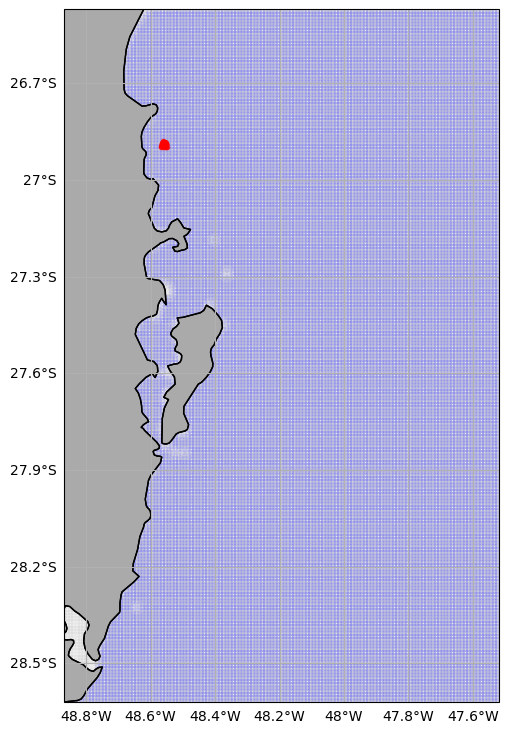

In [7]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

# Coastline
feature = NaturalEarthFeature(
    name="coastline",
    category="physical",
    scale="10m",
    edgecolor="#000000",
    facecolor="#AAAAAA",
)

bbox = (
    ds["longitude"].min().to_numpy()[()],
    ds["longitude"].max().to_numpy()[()],
    ds["latitude"].min().to_numpy()[()],
    ds["latitude"].max().to_numpy()[()],
)


def creat_map(projection=ccrs.PlateCarree(), figsize=(9, 9)):
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={
            "projection": projection,
        },
    )
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.coastlines(resolution="10m")
    return fig, ax


# Figure
fig, ax = creat_map(projection=ccrs.PlateCarree(), figsize=(9, 9))
ax.plot(x, y, "ro", zorder=2)
ax.plot(lons, lats, "r.", zorder=1, alpha=0.65)
ax.add_feature(feature, zorder=0)
ax.set_extent(bbox)

ax.plot(
    ds["longitude"],
    ds["latitude"],
    color="blue",
    marker="o",
    markerfacecolor="none",
    alpha=0.15,
    zorder=0,
)
X, Y = np.meshgrid(ds["m"], ds["n"])
ax.add_feature(feature, zorder=1)
ax.plot(x, y, "ro")  # Itajaí
ax.plot(X, Y, "k.", alpha=0.25, zorder=0, color="lightgrey");

In [8]:
from parcels import AdvectionRK4, StatusCode


def KeepInDomain(particle, fieldset, time):
    # https://github.com/euroargodev/VirtualFleet/blob/4e524f24e15c5dfc6b8b4f57836953b2ccc9eafe/virtualargofleet/virtualargofleet.py
    # out of geographical area : here we can delete the particle
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()


def Age(particle, fieldset, time):
    # Create a custom kernel which keeps track of the particle age (minutes)
    particle.age += particle.dt / 3600


output_file = pset.ParticleFile(
    name="results-model_tides_and_winds.zarr", outputdt=timedelta(hours=12)
)

# kernels = pset.Kernel(AdvectionRK4) + pset.Kernel(KeepInDomain) + pset.Kernel(Age)
kernels = [AdvectionRK4, KeepInDomain, Age]

pset.execute(
    kernels,
    runtime=timedelta(days=90),
    dt=timedelta(hours=6),
    output_file=output_file,
)

INFO: Output files are stored in results-model_tides_and_winds.zarr.
  0%|                                                                                                                                                            | 0/7776000.0 [00:00<?, ?it/s]WARNING: ParticleFile chunks are set to (10, 1), but this may lead to a significant slowdown in Parcels when many calls to repeatdt. Consider setting a larger chunk size for your ParticleFile (e.g. chunks=(int(1e4), 1)).
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7776000.0/7776000.0 [03:11<00:00, 40617.40it/s]


In [9]:
from pathlib import Path


def normalize_speed(u, v):
    u_norm = u / np.sqrt(u**2.0 + v**2.0)
    v_norm = v / np.sqrt(u**2.0 + v**2.0)
    speed = (u**2 + v**2) ** 0.5
    return (u_norm, v_norm, speed)


fname = Path("avg-model_tides_and_winds.nc")
if not fname.exists():
    avg = ds.mean(dim="time")
    avg.to_netcdf(fname)
else:
    avg = xr.load_dataset(fname)

u = avg["velocity_x"].squeeze()
v = avg["velocity_y"].squeeze()
u_norm, v_norm, speed = normalize_speed(u, v)

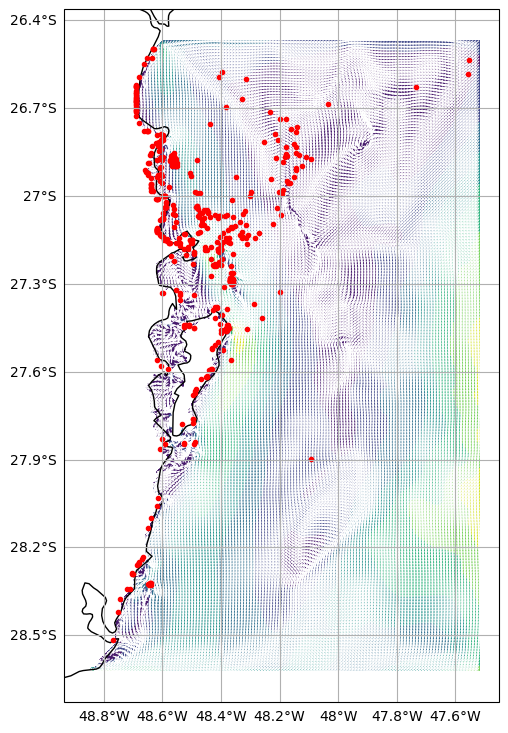

In [10]:
fig, ax = creat_map()
ax.contourf(avg["longitude"], avg["latitude"], speed)
ax.quiver(
    avg["longitude"],
    avg["latitude"],
    u_norm,
    v_norm,
    color="white",
    scale=50,
)

ax.plot(x, y, "bo", label="Itajaí")

for p in pset:
    ax.plot(p.lon, p.lat, "r.")

## Plot all trajectories

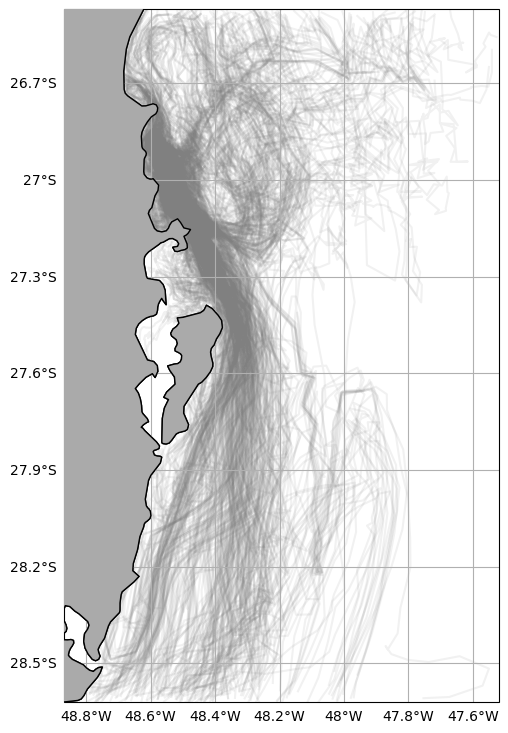

In [11]:
import warnings

import trajan  # noqa
import xarray as xr

warnings.simplefilter("ignore")

ds = xr.open_zarr("results-model_tides_and_winds.zarr")

fig, ax = creat_map()
ds.traj.plot(ax=ax)
ax.add_feature(feature, zorder=99)
ax.set_extent(bbox)

In [12]:
import geopandas


def parcels_to_geopandas(ds, GB=5, suppress_warnings=False):
    """
    Converts your parcels data to a geopandas dataframe containing a point for
    every observation in the dataframe. Custom particle variables come along
    for the ride during the transformation. Any undefined observations are removed
    (correspond to the particle being deleted, or not having entered the simulation).

    Assumes your parcel output is in lat and lon.

    Parameters
    ----------
    ds : xr.Dataset
        Dataset object in the format of parcels output.

    suppress_warnings : bool
        Whether to ignore RAM warning.

    Returns
    -------
    geopandas.GeoDataFrame
        GeoDataFrame with point data for each particle observation in the dataset.
    """
    RAM_LIMIT_BYTES = GB * 1000 * 1000  #  GB RAM limit

    if ds.nbytes > RAM_LIMIT_BYTES and not suppress_warnings:
        raise MemoryError(
            f"Dataset is {ds.nbytes:_} bytes, but RAM_LIMIT_BYTES set max to be {RAM_LIMIT_BYTES:_}."
        )

    df = (
        ds.to_dataframe().reset_index()  # Convert `obs` and `trajectory` indices to be columns instead
    )

    gdf = (
        geopandas.GeoDataFrame(
            df, geometry=geopandas.points_from_xy(df["lon"], df["lat"])
        )
        .drop(
            ["lon", "lat"], axis=1
        )  # No need for lon and lat cols. Included in geometry attribute
        .set_crs(
            "EPSG:4326"
        )  # Set coordinate reference system to EPSG:4326 (aka. WGS84; the lat lon reference system)
    )

    # Remove observations with no time from gdf (indicate particle has been removed, or isn't in simulation)
    invalid_observations = gdf["time"].isna()
    return gdf[~invalid_observations]


gdf_parcels = parcels_to_geopandas(ds)
gdf_parcels

,trajectory,obs,age,time,z,geometry
0,0,0,6.0,2021-01-01 00:00:00,0.0,POINT (-48.56844 -26.89435)
1,0,1,18.0,2021-01-01 12:00:00,0.0,POINT (-48.58415 -26.95082)
2,0,2,30.0,2021-01-02 00:00:00,0.0,POINT (-48.59007 -26.97417)
3,0,3,42.0,2021-01-02 12:00:00,0.0,POINT (-48.58817 -26.99738)
4,0,4,54.0,2021-01-03 00:00:00,0.0,POINT (-48.58598 -27.02433)
...,...,...,...,...,...,...
161461,897,1,18.0,2021-03-31 12:00:00,0.0,POINT (-48.55270 -26.90037)
161640,898,0,6.0,2021-03-31 00:00:00,0.0,POINT (-48.56292 -26.88091)
161641,898,1,18.0,2021-03-31 12:00:00,0.0,POINT (-48.56295 -26.89202)
161820,899,0,6.0,2021-03-31 00:00:00,0.0,POINT (-48.55693 -26.89610)


# Filter trajectories after first beaching

There are two land masks, one with Bonbinhas and another with without. Both where created with the `polygon_roi.ipynb` notebook.

In [13]:
roi = geopandas.read_file("data/roi-no-bombinhas.geojon")["geometry"].squeeze()

filtered_traj = {}
beached = {}
for k, traj in gdf_parcels.groupby("trajectory"):
    mask = traj.within(roi)
    if any(mask):
        # The beached particle is the first one that hit land.
        b = traj[mask].iloc[0]
        beached.update({k: b})
        filtered_traj.update({k: traj.iloc[: b["obs"]]})
    else:
        filtered_traj.update({k: traj})

In [14]:
print(f"{len(beached)} particules beached out of {len(filtered_traj)} total.")

265 particules beached out of 900 total.


## Plot only filtered trajectories

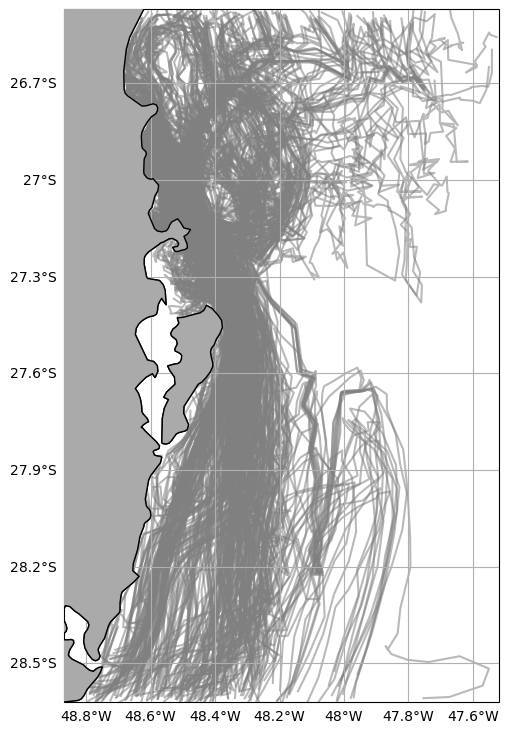

In [15]:
fig, ax = creat_map()

# non_beached = set(beached.keys()).symmetric_difference(ds["trajectory"].to_numpy())
# non_beached = ds.sel(trajectory=list(non_beached))
# filtered_traj.traj.plot(ax=ax)

for traj in filtered_traj.values():
    ax.plot(traj["geometry"].x, traj["geometry"].y, color="gray", alpha=0.55)
ax.add_feature(feature, zorder=99)
ax.set_extent(bbox)

In [16]:
import folium
from folium.plugins import Fullscreen

m = folium.Map()
for k, point in beached.items():
    folium.GeoJson(point["geometry"]).add_to(m)
    trajectory = gdf_parcels.loc[gdf_parcels["trajectory"] == point["trajectory"]]
folium.GeoJson(roi).add_to(m)
m.fit_bounds(m.get_bounds())
Fullscreen().add_to(m)
m

## All particles

In [17]:
import contextily
import numpy as np
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 15))
gdf_parcels.plot(ax=ax, markersize=0.1, color="k", zorder=2)
g = sns.kdeplot(
    data=gdf_parcels,
    x=gdf_parcels["geometry"].x,
    y=gdf_parcels["geometry"].y,
    fill=True,
    cmap="crest",
    alpha=0.6,
    levels=7,
)

contextily.add_basemap(
    ax=ax,
    crs=gdf_parcels.crs,
)

ModuleNotFoundError: No module named 'contextily'

In [ ]:
ds_beached = ds.sel(trajectory=list(beached.keys()))

gdf_beached = parcels_to_geopandas(ds_beached)
gdf_beached

fig, ax = plt.subplots(figsize=(15, 15))
gdf_parcels.plot(ax=ax, markersize=0.1, color="k", zorder=2)
g = sns.kdeplot(
    data=gdf_beached,
    x=gdf_beached["geometry"].x,
    y=gdf_beached["geometry"].y,
    fill=True,
    cmap="crest",
    alpha=0.6,
    levels=7,
)

contextily.add_basemap(ax=ax, crs=gdf_beached.crs, source="OpenStreetMap.Mapnik")

# TODO

Implement the `CoastalProximityParticle` class is taken from [3] and creates a "beaching" effect for particles that have beem close to the shore for a number of days in the vicinity of the virtual shore line.

[3] https://github.com/VictorOnink/Modeling-Global-Plastic-Beaching/blob/main/generalBeachingScenarios.py